In [1]:
from matplotlib import pyplot
import numpy
import pandas
from scipy import special
from scipy import stats
import seaborn

import sensitivity_analysis


numpy.random.seed(1)

The model is the final size for a simple epidemic model, i.e. the number of people who ever get infected.

In [2]:
def model(beta, gamma, S_0=1):
    '''The final size for a simple SIR model.'''
    R_0 = beta * S_0 / gamma
    r_infinity = numpy.real_if_close(
        numpy.where(R_0 > 1,
                    1 + special.lambertw(- numpy.exp(- R_0)),
                    0))
    return r_infinity

Make distributions for $\beta$, $\gamma$, and maybe $S_0$ and calculate the sensitivity measures for the final size.

In [3]:
# Let the transmission rate be a Gamma random variable.
transmission_rate_mean = 0.03
transmission_rate_shape = 4
transmission_rate_scale = transmission_rate_mean / transmission_rate_shape
transmission_rate = stats.gamma(transmission_rate_shape,
                                scale=transmission_rate_scale)

# Let the recovery rate be a Gamma random variable.
recovery_rate_mean = 0.01
recovery_rate_shape = 4
recovery_rate_scale = recovery_rate_mean / recovery_rate_shape
recovery_rate = stats.gamma(recovery_rate_shape,
                            scale=recovery_rate_scale)

parameters = dict(beta=transmission_rate,
                  gamma=recovery_rate)

# Uncertainty analysis

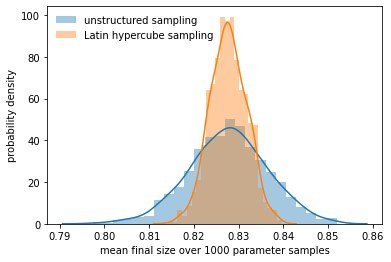

In [13]:
n_runs = 1000
n_samples = 1000


def get_mean_output(sampler, model, parameters, n_samples, n_runs):
    '''For each run in `n_runs`,
    find the mean output of `model()` 
    over `n_samples` samples from `parameters` using
    `sampler()`.'''
    means = []
    for _ in range(n_runs):
        parameter_samples = sampler(parameters, n_samples)
        model_outputs = model(**parameter_samples)
        means.append(numpy.mean(model_outputs))
    return means


means = get_mean_output(sensitivity_analysis.samples_unstructured,
                        model, parameters,
                        n_samples, n_runs)

means_LHS = get_mean_output(sensitivity_analysis.samples_Latin_hypercube,
                            model, parameters,
                            n_samples, n_runs)

seaborn.distplot(means, label='unstructured sampling')
seaborn.distplot(means_LHS, label='Latin hypercube sampling')
pyplot.xlabel(f'mean final size over {n_samples} parameter samples')
pyplot.ylabel('probability density')
_ = pyplot.legend()

# Sensitivity analysis

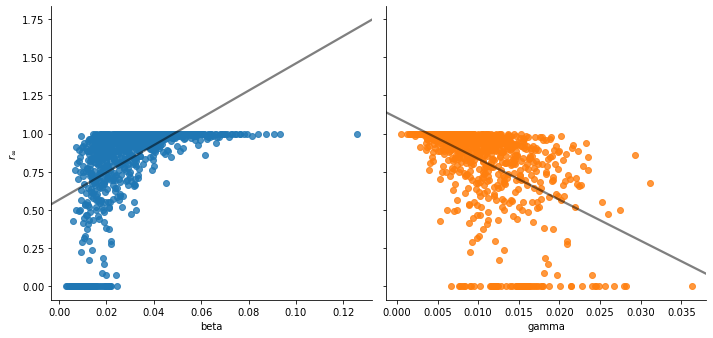

In [5]:
fg = sensitivity_analysis.scatterplots(model, parameters, n_samples=1000)
_ = fg.set_ylabels(r'$r_{\infty}$')

In [12]:
def bold_sum(s):
    '''Made the 'Sum' row bold.'''
    is_sum = (s.index == 'Sum')
    return ['font-weight: bold' if v else '' for v in is_sum]


def display_with_sums(table):
    '''Add column sums and display.'''
    table = table.copy()
    table.loc['Sum'] = table.sum()
    return table.style.apply(bold_sum)


n_samples = 1000
table = {}
# table[r'$S$'] = sensitivity_analysis.sensitivity(
#     model, parameters, n_samples, normalized=False)
# table[r'$\beta$'] = sensitivity_analysis.linreg_coefficients(
#     model, parameters, n_samples, normalized=False)
# table[r'$\nu$'] = sensitivity_analysis.DGSM(
#     model, parameters, n_samples, normalized=False)
table[r'$S_{\sigma}$'] = sensitivity_analysis.sensitivity(
    model, parameters, n_samples)
table[r'$\beta_{\sigma}$'] = sensitivity_analysis.linreg_coefficients(
    model, parameters, n_samples)
table[r'$\nu_{\sigma}$'] = sensitivity_analysis.DGSM(
    model, parameters, n_samples)
(S, _, S_T, _) = sensitivity_analysis.Sobol_indexes(
    model, parameters, n_samples)
table[r'$S$'] = S
table[r'$S_{\text{T}}$'] = S_T
table[r'$\rho_{\text{partial rank}}$'] = sensitivity_analysis.PRCC(
    model, parameters, n_samples)
table = pandas.DataFrame(table)
display_with_sums(table)

,$S_{\sigma}$,$\beta_{\sigma}$,$\nu_{\sigma}$,$S$,$S_{\text{T}}$,$\rho_{\text{partial rank}}$
beta,0.29603,0.5235,5.99718,0.565419,0.706984,0.948691
gamma,-0.295726,-0.528619,0.902186,0.340677,0.513128,-0.950311
Sum,0.000304008,-0.00511853,6.89936,0.906095,1.22011,-0.00161983


In [10]:
def display_Sobol_indexes(S, S_PE, S_T, S_T_PE, alpha=0.5):
    '''Display the Sobol' indexes S and S_T in a nice table.'''
    table = pandas.concat((S, S_PE, S_T, S_T_PE), axis='columns')
    CI_percent = 100 * (1 - alpha)
    columns = pandas.MultiIndex.from_product(
        (('First-order index ($S$)', r'Total-order index ($S_{\text{T}}$)'),
         ('Estimate', f'{CI_percent:g}% probable error')))
    table.set_axis(columns, axis='columns', inplace=True)
    table.loc['Sum'] = table.sum()
    # Don't show the sum of the probable errors.
    estimates = (columns.get_level_values(1) == 'Estimate')
    table.loc['Sum', ~estimates] = ''
    display(table.style.apply(bold_sum))


n_samples = 1000
alpha = 0.5
(S, S_PE, S_T, S_T_PE) = sensitivity_analysis.Sobol_indexes(
    model, parameters, n_samples, alpha=alpha)
display_Sobol_indexes(S, S_PE, S_T, S_T_PE, alpha=alpha)

# Problem

Plots the accuracy of the sensitivity measures vs. the number of model evaluations. Do this for:
* $S_{\sigma}$, the sigma-normalized sensitivity;
* $\beta_{\sigma}$, the sigma-normalized regression coefficients;
* maybe $v_{\sigma}$, the sigma-normalized DGSM;
* $S$, the first-order Sobol' index;
* $S_{\text{T}}$, the total-order Sobol' index; and
* maybe $\rho_{\text{partial rank}}$, the partial rank correlation coefficient.

(Should we use the squared $S_{\sigma}$ and $\beta_{\sigma}$ instead?)

What should we use to measure the error?
* the norm of the covariance matrix of the vector of sensitivities over many resamples.
(Should there be a square root somewhere?)

For $n$ samples of $k$ parameters:
* $S_{\sigma}$ needs $n + k + 1$ model evaluations;
* $\beta_{\sigma}$ needs $n$ model evaluations;
* $\nu_{\sigma}$ needs $(k + 1) n$ model evaluations;
* $S$ and $S_{\text{T}}$ together need $(k + 2) n$ model evaluations; and
* $\rho_{\text{partial rank}}$ needs $n$ model evaluations.